# LAD train/test/validation

## Init

In [1]:
from sklearn import linear_model

from f_data_prep import *
from f_drosophila_infer import *
from f_train import *

In [2]:
# cells_v = np.random.choice(6078, 608, replace=False)
# with open('./pickles/validation_cells.pkl', 'wb') as f:
#     pickle.dump(cells_v, f)

In [3]:
# with open('./pickles/validation_cells.pkl', 'rb') as f:
#     cells_v = pickle.load(f)

## Def

In [4]:
def LAD_cv_lin_cellselect(X, y, gene_comp=comp_ind, kf=10):
    kfold = KFold(n_splits=kf, shuffle=False)
    
    if len(gene_comp) > 0:
        X_in = np.copy(X[:, comp_ind])
    else:
        X_in = np.copy(X)
        
    w_list = []
    bias_list = []
    
    val = np.hstack([cells_v+(6078*i) for i in range(5)])
    cells_tt = np.delete(range(6078), cells_v)
    tr_te = np.hstack([cells_tt+(6078*i) for i in range(5)])
    
    X_v = X_in[val]
    y_v = y[val]
    X_tt = X_in[tr_te]
    y_tt = y[tr_te]
    
    for (cell_tr, cell_te) in (kfold.split(range(5470))):
        te = np.hstack([cell_te+(5470*i) for i in range(5)])
        tr = np.delete(range(27350), te)
        X_tr, y_tr = X_tt[tr], y_tt[tr]
        X_te, y_te = X_tt[te], y_tt[te]
        
        w,bias = infer_LAD_v(X_tr, y_tr, X_te, y_te)
        w_list.append(w)
        bias_list.append(bias)
        
    w = np.mean(w_list, axis=0)
    bias = np.mean(bias_list, axis=0)
    
    print(w.shape, bias.shape)
    if y.shape[1] == 27:
        X_init = np.copy(X[:, comp_ind][val])
    else:
        X_init = np.copy(X[val])
    
    yp = X_init + bias + X_v.dot(w)
    yp[yp<0] = 0
    ya = X_init + y_v
    ferror = np.sum(np.abs(yp - ya), axis=0)/np.sum(np.abs(ya), axis=0)
    error1 = np.abs(yp - ya)
    
    dic = {
        'ferror': ferror,
        'error_cell_l1': error1,
        'w': w,
        'bias': bias
    }
    return dic

def infer_all_LAD(X_all, y_all, y_comp):
    res=[]
    results = LAD_cv_lin_cellselect(X_all, y_all, gene_comp=[], kf=10)
    res.append(results)
    results = LAD_cv_lin_cellselect(X_all, y_comp, gene_comp=[], kf=10)
    res.append(results)
    results = LAD_cv_lin_cellselect(X_all, y_comp, gene_comp=comp_ind, kf=10)
    res.append(results)
    return res

## Separating validation set

In [5]:
data_all = np.loadtxt('../data_complete.txt')
all_bin = np.vsplit(data_all, 6)
all_init = np.vstack([all_bin[i] for i in range(5)])
all_diff = np.vstack([all_bin[i+1]-all_bin[i] for i in range(5)])

complete_all = ([int(x) - 1 for x in open('../indices_complete.txt','r').readline().split()])
comp_ind = list(map(int, list((np.array(complete_all)[::6]-3)/6)))

data_comp = np.copy(data_all[:, comp_ind])
comp_bin = np.vsplit(data_comp, 6)
comp_diff = np.vstack([comp_bin[i+1] - comp_bin[i] for i in range(5)])

## Run

In [6]:
# LAD_lin_cellselect = infer_all_LAD(all_init, all_diff, comp_diff)

In [7]:
# with open('./pickles/LAD_lin_ttv.pkl', 'wb') as f:
#     pickle.dump(LAD_lin_cellselect, f)

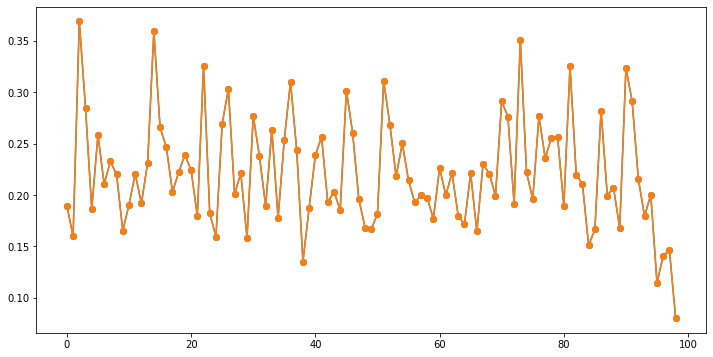

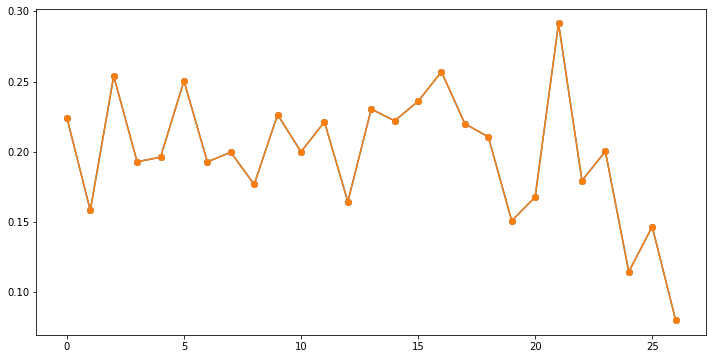

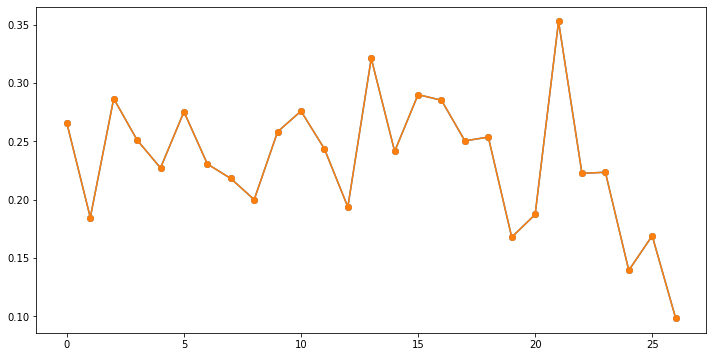

In [8]:
with open('./pickles/LAD_lin_ttv.pkl', 'rb') as f:
    res = pickle.load(f)
with open('./pickles/LAd_lin_ttv_neg.pkl', 'rb') as f:
    res_neg = pickle.load(f)

gene_comp = [[],[],comp_ind]
X = np.copy(all_init)
y_list = [np.copy(all_diff), np.copy(comp_diff), np.copy(comp_diff)]

for i in range(3):
    y = y_list[i]
    w = res[i]['w']
    bias = res[i]['bias']
    ferror = res[i]['ferror']
    
    if len(gene_comp[i]) > 0:
        X_in = np.copy(X[:, comp_ind])
    else:
        X_in = np.copy(X)
        
    val = np.hstack([cells_v+(6078*i) for i in range(5)])
    
    X_v = X_in[val]
    y_v = y[val]
    
    if bias.shape[1] == 27:
        X_init = np.copy(X[:, comp_ind][val])
    else:
        X_init = np.copy(X[val])
    
    yp = X_init + bias + X_v.dot(w)
    ya = X_init + y_v
    ferror = np.sum(np.abs(yp - ya), axis=0)/np.sum(np.abs(ya), axis=0)
    
    plt.figure(figsize=(12,6))
#     plt.plot(range(len(ferror)), res[i]['ferror'], 'o-')
    plt.plot(range(len(ferror)), res_neg[i]['ferror'], 'o-')
    plt.plot(range(len(ferror)), ferror, 'o--')

In [9]:
with open('./pickles/LAD_quad_ttv.pkl', 'rb') as f:
    LAD_quad = pickle.load(f)
    
with open('./pickles/LAD_lin_ttv.pkl', 'rb') as f:
    LAD_lin = pickle.load(f)

## Results

### LAD vs. LAD_v

In [10]:
# def quad(X):
#     quad = np.copy(X)
#     if X.shape[1] == 27:
#         for i in range(X.shape[1]-1):
#             for j in range(i+1, X.shape[1]):
#                 quad = np.hstack((quad, (X[:,i]*X[:,j])[:,None]))
#     if X.shape[1] == 99:
#         for i in range(len(comp_ind)-1):
#             for j in range(i+1, len(comp_ind)):
#                 quad = np.hstack((quad, (X[:,comp_ind[i]]*X[:,comp_ind[j]])[:,None]))
#     return quad

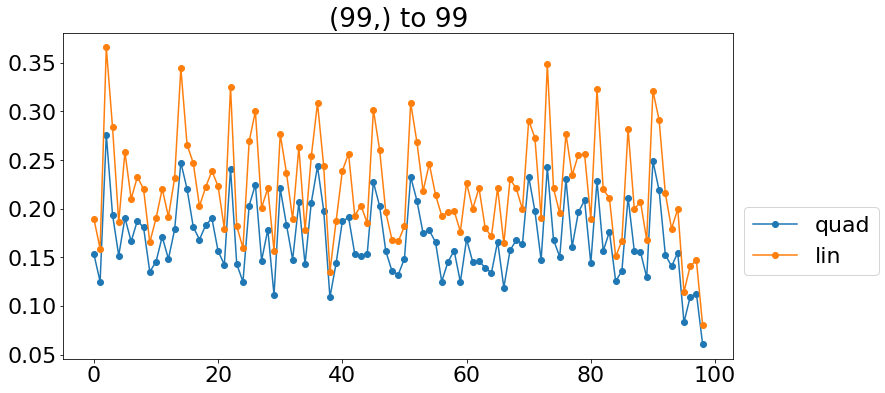

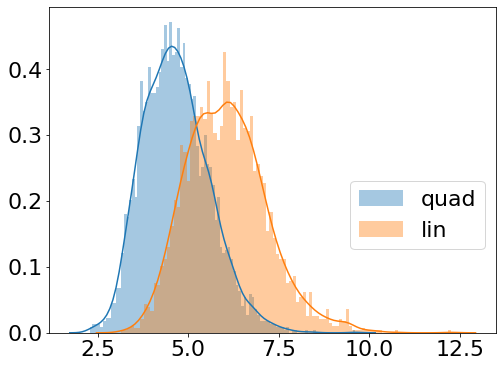

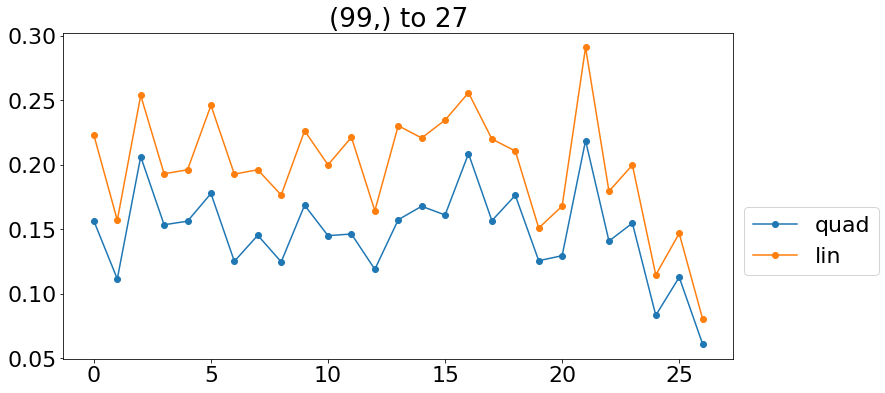

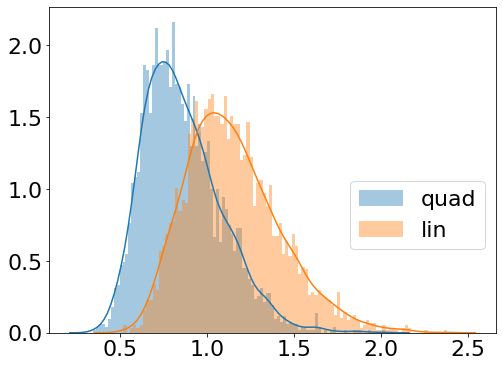

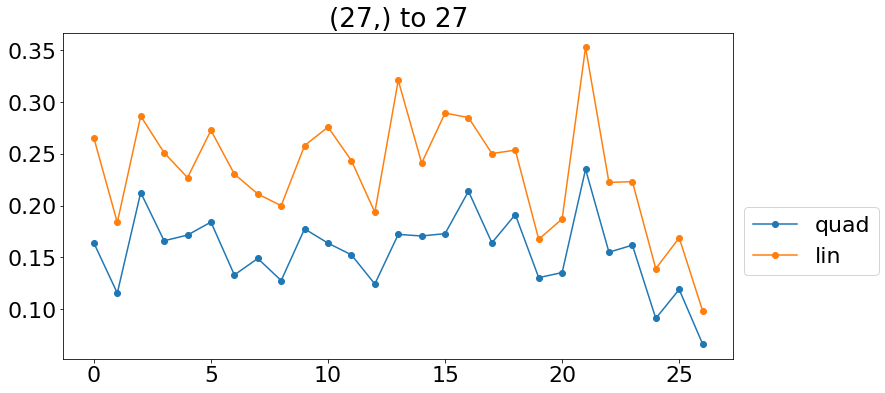

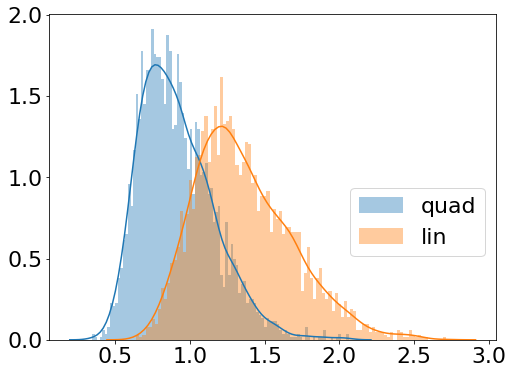

In [13]:
import seaborn as sns

matplotlib.rcParams.update({'font.size': 22})
title=['(99,) to 99', '(99,) to 27', '(27,) to 27', '(27,) to 99']
for i in range(3):
    plt.figure(figsize=(12,6))
    plt.plot(range(len(LAD_quad[i]['ferror'])), LAD_quad[i]['ferror'], 'o-', label='quad')
    plt.plot(range(len(LAD_lin[i]['ferror'])), LAD_lin[i]['ferror'], 'o-', label='lin')
    plt.legend(bbox_to_anchor=(1,0.5))
    plt.title(title[i])
    
    plt.figure(figsize=(8,6))
    error_l1 = np.sum(LAD_quad[i]['error'], axis=1)
    sns.distplot(error_l1, bins=100, label='quad')
    error_l1 = np.sum(LAD_lin[i]['error_cell_l1'], axis=1)
    sns.distplot(error_l1, bins=100, label='lin')
    plt.legend(bbox_to_anchor=(1,0.5))
#     print(stats.mannwhitneyu(LAD_quad[i]['error1'], LAD_lin[i]['error_cell_l1']))
plt.show()

### LAD_v: (99,27) to 27 vs. (27,27) to 27

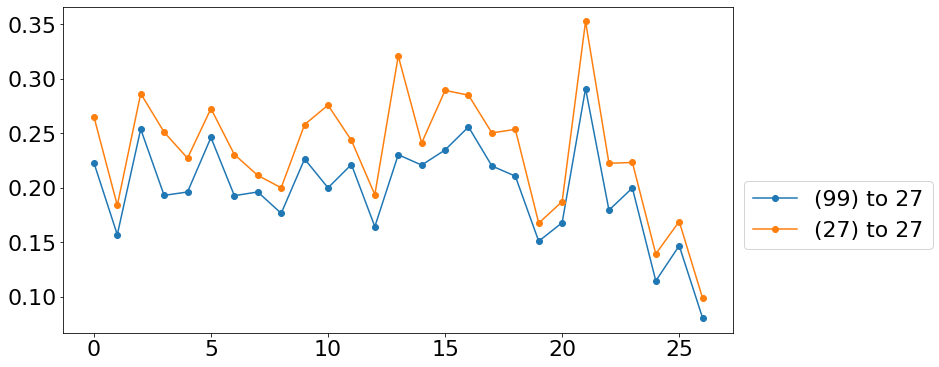

In [14]:
plt.figure(figsize=(12,6))
labels=['(99) to 27', '(27) to 27']
for i in range(1,3):
    plt.plot(range(27), LAD_lin[i]['ferror'], 'o-', label=labels[i-1])
    plt.legend(bbox_to_anchor=(1,0.5))
plt.show()

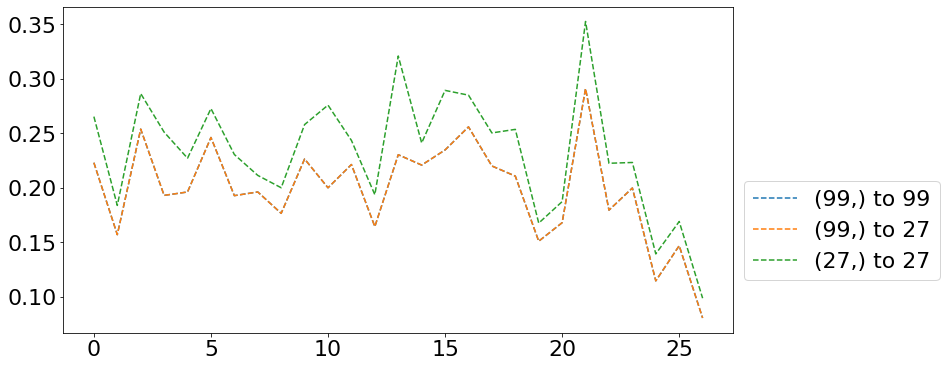

In [16]:
plt.figure(figsize=(12,6))
labels=['(99,) to 99', '(99,) to 27', '(27,) to 27', '(27,) to 99']
for i in range(3):
    if len(LAD_lin[i]['ferror']) == 27:
        plt.plot(range(27), LAD_lin[i]['ferror'], '--', label=labels[i])
    else:
        plt.plot(range(27), LAD_lin[i]['ferror'][comp_ind], '--', label=labels[i])
    plt.legend(bbox_to_anchor=(1,0.5))
plt.show()